# TEA-DT Community Pulse Check - Internal Report

# Study Objectives

This study was conducted by the Innovation & Impact Hub, part of the Turing Research and Innovation cluster for digital twins. The aim was to explore the challenges and opportunities for assurance of digital twins within the community, with a particular focus on the application of high-level guiding principles such as the Gemini Principles.

**The study was divided into three main topics and for each topic we defined a set of research questions**

- **topic 1:** Current understanding and practices in assuring digital twins.
	- **RQ1**: What is the make-up and maturity of the surveyed digital twin community?
	- **RQ2:** What is the community's current understanding of assurance?
	- **RQ3:** What practices are being used, including methods and properties assured?

- **topic 3:** Attitudes & perceived challenges in putting ethical and trustworthy digital twin principles into practice.
	- **RQ4**: How satisfied is the community with their assurance practices?
	- **RQ5:** How does the community perceive guiding principles (eg Gemini Principles)?
	- **RQ6:** What challenges do people encounter when putting the Gemini Principles into practice?

- **topic 4:** Readiness for, and attitudes towards, new tools for argument-based assurance.
	- **RQ7:** What is the community's readiness for argument-based assurance methods?
	- **RQ8**: What support is needed for successful adoption?

In [823]:
# %% 
# Imports
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
from scipy.cluster.hierarchy import linkage, leaves_list, fcluster
from scipy.stats import chi2_contingency

In [824]:
# Define Plotting functions  

# Set default font sizes for all plots
plt.rcParams.update({
    'axes.titlesize': 16,  # Font size for titles
    'axes.labelsize': 14,  # Font size for axis labels
    'xtick.labelsize': 14,  # Font size for x-tick labels
    'ytick.labelsize': 14,  # Font size for y-tick labels
    'legend.fontsize': 14,  # Font size for legend
    'font.size': 14         # General font size
})

def melt_multiple_select(df, columns, new_col_name):
    flattened_df = pd.DataFrame()

    for col in columns:
        if df[col].apply(lambda x: isinstance(x, list)).any():
            # If the column contains lists, flatten them
            flat_col = df.explode(col).reset_index(drop=True)
            flattened_df = pd.concat([flattened_df, flat_col], axis=0)
        else:
            # If the column contains strings, just concatenate
            flattened_df = pd.concat([flattened_df, df[['_id', col]]], axis=0)
    
    # After all columns are processed, melt the DataFrame
    melted_df = flattened_df.melt(id_vars=['_id'], value_vars=columns, var_name='variable', value_name=new_col_name)

    # Drop rows where the value in new_col_name is NaN or empty
    melted_df = melted_df.dropna(subset=[new_col_name]).reset_index(drop=True)

    # Filter out entries where the column name contains "other" and the value is "Other"
    other_columns = [col for col in columns if 'other' in col.lower()]
    if other_columns:
        melted_df = melted_df[~(melted_df[new_col_name] == "Other")]


    return melted_df

def plot_pie_chart(df, category_col, title="Pie Chart", highlight=None, dpull=0, label_length=100, palette=None, outfile=None):
    df[category_col] = df[category_col].astype(str).str[:label_length]
    # Count the occurrences for each category
    counts = df[category_col].value_counts().reset_index()
    counts.columns = [category_col, 'count']
    
    # Determine which sections to highlight
    if highlight is None:
        pull = [dpull] * len(counts)
    else:
        if isinstance(highlight, str):
            highlight = [highlight]
        pull = [dpull if counts[category_col][i] in highlight else 0 for i in range(len(counts))]

    # Plot the pie chart
    fig = px.pie(counts, values='count', names=category_col, title=title,
                 color_discrete_sequence=palette)
    
    # Update layout to show labels outside the pie chart with leader lines
    fig.update_traces(textinfo='label', textposition='outside', showlegend=False,
                      marker=dict(line=dict(color='#000000', width=2)), pull=pull,
                      hole=0.3, textfont_size=16)

    # Add title and adjust margins
    fig.update_layout(title_text=title, title_x=0.5, margin=dict(t=50, b=0, l=0, r=0))
    
    if outfile:
        fig.write_image(f"{outfile}.svg")

    return fig

def barplot_grouped(df, plot_val, group_by, group1, group2, category_order=None, color_palette=None):
    # Filter the DataFrame for the specified roles
    filtered_df = df[df[group_by].isin([group1, group2])]

    # Calculate the frequency counts
    freq_counts = filtered_df.groupby([plot_val, group_by]).size().unstack(fill_value=0).reset_index()

    # Calculate the total count of unique respondents for each group
    total_counts = df.groupby(group_by)['_id'].nunique()

    # Convert frequencies to percentages
    freq_counts[f'{group1}_percent'] = (freq_counts[group1] / total_counts[group1]) * 100
    freq_counts[f'{group2}_percent'] = (freq_counts[group2] / total_counts[group2]) * 100

    # Sort by difference in percentages
    freq_counts['diff'] = abs(freq_counts[f'{group1}_percent'] - freq_counts[f'{group2}_percent'])
    freq_counts = freq_counts.sort_values(by='diff', ascending=False)

    # Create a new DataFrame for plotting
    plot_df = pd.DataFrame({
        plot_val: pd.concat([freq_counts[plot_val], freq_counts[plot_val]]),
        group_by: [group1] * len(freq_counts) + [group2] * len(freq_counts),
        'Frequency': pd.concat([freq_counts[group1], freq_counts[group2]]),
        'Percentage': pd.concat([freq_counts[f'{group1}_percent'], freq_counts[f'{group2}_percent']])
    })

    # Create the bar plot
    fig = px.bar(plot_df, x=plot_val, y='Percentage', color=group_by, barmode='group',
                 title=f'Percentage Frequency of {plot_val} for {group_by} "{group1}" and "{group2}"',
                 hover_data={'Frequency': True},
                category_orders={plot_val: category_order},
                color_discrete_sequence=color_palette)

    # Update layout
    fig.update_layout(xaxis_title=plot_val, yaxis_title='Percentage')

    # Show the plot
    fig.show()
    
def barplot(df, plot_val, category_order=None, palette=None, outfile=None):
    # Calculate the total count of unique respondents (using _id)
    total_count = df['_id'].nunique()

    # Calculate the frequency counts
    freq_counts = df.groupby(plot_val)['_id'].nunique().reset_index()
    freq_counts.columns = [plot_val, 'Frequency']

    # Convert frequencies to percentages based on the total unique _id count
    freq_counts['Percentage'] = (freq_counts['Frequency'] / total_count) * 100
    # Sort by percentage
    freq_counts = freq_counts.sort_values(by='Percentage', ascending=True)

    # Create the bar plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(data=freq_counts, y=plot_val, x='Percentage', palette=palette, order=category_order)

    # Customize the grid and background
    ax = plt.gca()  # Get current axes
    ax.set_facecolor('#E8E8E8')  # Set grey background
    ax.grid(axis='x', color='white', linestyle='-', linewidth=1)  # White vertical lines
    ax.grid(axis='y', linestyle='')  # Remove horizontal lines
    ax.tick_params(length=0)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))  # Control number of ticks on the x-axis

    # Customize the grid: remove horizontal lines but keep vertical ones
    plt.grid(axis='y', linestyle='')  # Remove horizontal lines
    plt.grid(axis='x', linestyle='-')  # Keep vertical lines
    # Ensure the bars are in front of the grid lines
    for bar in ax.patches:
        bar.set_zorder(3)

    # Remove the black frame (spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Update the layout
    plt.title(f'Percentage of {plot_val} based on Unique Respondents')
    plt.xlabel('Percentage')
    plt.ylabel(plot_val)

    plt.tight_layout()

    if outfile:
        plt.savefig(outfile, format='svg')
    plt.show()

def stacked_barplot(df, plot_val, group_by_dict, category_order=None, palette=None, outfile=None):
    # Create a new column in the DataFrame based on the group_by_dict
    df_cleaned = df.dropna(subset=[plot_val])
        
    df['Grouping'] = df_cleaned[plot_val].map({val: key for key, vals in group_by_dict.items() for val in vals})
    
    # Calculate the frequency counts for each Grouping and plot_val combination
    freq_counts = df.groupby([plot_val, 'Grouping'])['_id'].nunique().reset_index()
    freq_counts.columns = [plot_val, 'Grouping', 'Frequency']

    # Sort the groupings by category order if provided
    if category_order is not None:
        freq_counts['Grouping'] = pd.Categorical(freq_counts['Grouping'], categories=category_order, ordered=True)

    # Pivot the data for a stacked bar plot
    freq_pivot = freq_counts.pivot_table(index='Grouping', columns=plot_val, values='Frequency', fill_value=0)
    
    fig = go.Figure()

    # Iterate through each group (index) in freq_pivot
    for group_idx, group in enumerate(freq_pivot.index):
        # Find columns with non-zero values for the current group
        non_zero_columns = freq_pivot.loc[group][freq_pivot.loc[group] > 0]
        
        # Sort the non-zero columns by value (descending order) for each group
        non_zero_columns = non_zero_columns.sort_values(ascending=False)
        
        # Assign colors based on the number of non-zero columns
        colors = palette[group_idx][:len(non_zero_columns)]
        
        # Plot the non-zero columns for this group, with sub-stacks sorted by size
        fig.add_trace(go.Bar(
            y=[group] * len(non_zero_columns),  # Repeat the group name for each non-zero column
            x=non_zero_columns.values,  # Frequencies for each non-zero column
            name=group,  # Group name
            orientation='h',
            #text=non_zero_columns.index,  # Display column names on the sub-stacks
            #textposition='auto',  # Automatically position the text
            marker=dict(
            color=colors,  # Assign the corresponding colors
            line=dict(color='white', width=4)  # Set the border color to white and width to 3pt
            ),
            showlegend=group_idx == 0  # Show legend only for the first group
        ))
    
    # Update layout for better appearance
    fig.update_layout(
        barmode='stack',
        title='Count of Sub-items in Each Group',
        width=1200,
        xaxis_title='Count',
        yaxis_title='Grouping',
        yaxis=dict(categoryorder='array', categoryarray=category_order),  # Apply the category order
        plot_bgcolor='rgba(0,0,0,0)',
        showlegend=True,
        legend_title_text='Sub-items'
    )

    # Show the plot
    if outfile:
        fig.write_image(outfile, format="svg")
    fig.show()

def plot_role_frequencies(df, plot_val, group_by='role', sel1='Senior Management', sel2='Research and Development', category_order=None, palette=None):
    # Filter the DataFrame for the specified roles
    filtered_df = df[df[group_by].isin([sel1, sel2])]

    # Calculate the frequency counts
    freq_counts = filtered_df.groupby([plot_val, group_by]).size().unstack(fill_value=0).reset_index()

    # Calculate the total count of unique respondents for each group
    total_counts = df.groupby(group_by)['_id'].nunique()

    # Convert frequencies to percentages
    freq_counts[f'{sel1}_percent'] = (freq_counts[sel1] / total_counts[sel1]) * 100
    freq_counts[f'{sel2}_percent'] = (freq_counts[sel2] / total_counts[sel2]) * 100

    # Sort by difference in percentages
    freq_counts['diff'] = abs(freq_counts[f'{sel1}_percent'] - freq_counts[f'{sel2}_percent'])
    freq_counts = freq_counts.sort_values(by='diff', ascending=False)

    # Create a new DataFrame for plotting
    plot_df = pd.DataFrame({
        plot_val: pd.concat([freq_counts[plot_val], freq_counts[plot_val]]),
        group_by: [sel1] * len(freq_counts) + [sel2] * len(freq_counts),
        'Frequency': pd.concat([freq_counts[sel1], freq_counts[sel2]]),
        'Percentage': pd.concat([freq_counts[f'{sel1}_percent'], freq_counts[f'{sel2}_percent']])
    })

    # Create the bar plot
    fig = px.bar(plot_df, x=plot_val, y='Percentage', color=group_by, barmode='group',
                 title=f'Percentage Frequency of {plot_val} for {group_by} "{sel1}" and "{sel2}"',
                 hover_data={'Frequency': True},
                category_orders={plot_val: category_order},
                color_discrete_sequence=palette)

    # Update layout
    fig.update_layout(xaxis_title=plot_val, yaxis_title='Percentage')

    # Show the plot
    fig.show()


In [825]:
color_hex_codes = {
    # Blues
    "Cyan": "#00B4DF",        # 100% color
    "Cyan_25": "#40C7E7",     # 75% color, 25% white
    "Cyan_50": "#80D9EF",     # 50% color, 50% white
    "Cyan_75": "#BFECF7",      # 25% color, 75% white
    
    "Blue": "#0073B4",        # 100% color
    "Blue_25": "#4096C7",     # 75% color, 25% white
    "Blue_50": "#80B9DA",     # 50% color, 50% white
    "Blue_75": "#BFDCEC",     # 25% color, 75% white
    
    # Greens
    "Green": "#337538",       # 100% color
    "Green_25": "#66976A",    # 75% color, 25% white
    "Green_50": "#99BA9B",    # 50% color, 50% white
    "Green_75": "#CCDCCD",    # 25% color, 75% white
    
    "BlueGreen": "#009D72",        # 100% color
    "BlueGreen_25": "#40B595",     # 75% color, 25% white
    "BlueGreen_50": "#80CEB8",     # 50% color, 50% white
    "BlueGreen_75": "#BFE6DC",     # 25% color, 75% white

    "Teal": "#5DA899",        # 100% color
    "Teal_25": "#85BEB2",     # 75% color, 25% white
    "Teal_50": "#AED3CC",     # 50% color, 50% white
    "Teal_75": "#D6E9E5",     # 25% color, 75% white
    
    # Yellows
    "Yellow": "#CCBB40",      # 100% color
    "Yellow_25": "#D9CC70",   # 75% color, 25% white
    "Yellow_50": "#E5DD9F",   # 50% color, 50% white
    "Yellow_75": "#F2EECF",   # 25% color, 75% white
    
    "Lemon": "#F0E442",       # 100% color
    "Lemon_25": "#F4EB71",    # 75% color, 25% white
    "Lemon_50": "#F7F1A0",    # 50% color, 50% white
    "Lemon_75": "#FBF8D0",    # 25% color, 75% white
    
    # Oranges
    "Orange": "#E69F03",      # 100% color
    "Orange_25": "#ECB742",   # 75% color, 25% white
    "Orange_50": "#F2CF81",   # 50% color, 50% white
    "Orange_75": "#F9E7C0",   # 25% color, 75% white
    
    # Reds
    "Red": "#D45F14",         # 100% color
    "Red_25": "#DF874F",      # 75% color, 25% white
    "Red_50": "#E9AF89",      # 50% color, 50% white
    "Red_75": "#F4D7C4",      # 25% color, 75% white
    
    # Pinks
    "Pink": "#CC78A7",        # 100% color
    "Pink_25": "#D99ABD",     # 75% color, 25% white
    "Pink_50": "#E5BBD3",     # 50% color, 50% white
    "Pink_75": "#F2DDE9",     # 25% color, 75% white
    
    "Magenta": "#9F4A96",     # 100% color
    "Magenta_25": "#B777B0",  # 75% color, 25% white
    "Magenta_50": "#CFA4CA",  # 50% color, 50% white
    "Magenta_75": "#E7D2E5",  # 25% color, 75% white
    
    # Purples
    "Purple": "#812C55",      # 100% color
    "Purple_25": "#A06180",   # 75% color, 25% white
    "Purple_50": "#C095AA",   # 50% color, 50% white
    "Purple_75": "#DFC4D4",   # 25% color, 75% white
    
    # Grays
    "Gray": "#BBBBBB",        # 100% color
    "Gray_25": "#E8E8E8",     # 75% color, 25% white
}

def select_colors(total_items, primary_colors):

    # Calculate how many mixed colors are needed per primary color
    num_primary = len(primary_colors)
    num_mixed_per_primary = (total_items - num_primary) // num_primary
    
    if (total_items - num_primary) % num_primary != 0:
        num_mixed_per_primary += 1

    selected_colors = []
    
    # Iterate over each primary color in the specified list
    for color in primary_colors:
        selected_colors.append(color_hex_codes[color])
        if len(selected_colors) < total_items:
            if num_mixed_per_primary >= 1:
                selected_colors.append(color_hex_codes.get(f"{color}_25"))
            if num_mixed_per_primary >= 2 and len(selected_colors) < total_items:
                selected_colors.append(color_hex_codes.get(f"{color}_50"))
            if num_mixed_per_primary >= 3 and len(selected_colors) < total_items:
                selected_colors.append(color_hex_codes.get(f"{color}_75"))

    return selected_colors[:total_items]

# Example usage
#colors_for_6_items = select_colors(6, ['Cyan', 'Green', 'Yellow'])  # Select 3 primary colors and 1 mixed version for each

In [826]:
# Load Data
csv_file_path = 'tea_dt_data_full.csv'
df = pd.read_csv(csv_file_path)

In [827]:
print("Total number of responses:",df.shape[0])

df['time_spent_minutes'] = (pd.to_datetime(df['modification_date']) - pd.to_datetime(df['start_timestamp'])).dt.total_seconds() / 60.0
print("Mean duration spent on survey:", df['time_spent_minutes'].mean())

Total number of responses: 50
Mean duration spent on survey: 18.1


/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_27901/2952236126.py:3: UserWarning:

Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_27901/2952236126.py:3: UserWarning:

Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



# Methodology

### sample / distribution

This survey was set up by the Turing TRIC team and distributed across multiple networks, supported by the Connected Places Catapult Digital Twin Hub community. The survey aimed to gather insights from digital twin practitioners and was shared with a number of digital twinning communities, including the Connected Places Catapult Digital Twin Hub community (comprising industry, academia, and public sector members), the DTnet+ community (an academic network of digital twin practitioners), and the broader Alan Turing Institute network. The survey was conducted completely anonymous and we did not collect any sensitive data per default. Respondents could choose to submit their email address for the purpose of being contacted for events related to this piece of work.

### Survey Distribution and Recruitment
Participants were recruited through community newsletters and social media, targeting those involved in digital twinning activities across sectors. The survey received a total of 50 responses, representing a broad spectrum of roles, including leadership, technical specialists, and research positions. The responses were roughly evenly split between these categories. Most participants reported balancing a range of responsibilities, including technical decision-making and operational management, while only four indicated "Compliance" as their primary responsibility.

### Preprocessing

In [828]:
# cleaning cells
def split_at_parentheses(text):
    if isinstance(text, str):
        return text.split('(')[0].strip()
    return text

def melt_multiple_select(df, columns, new_col_name):
    melted_df = df.melt(id_vars=['_id'], value_vars=columns, var_name='variable', value_name=new_col_name).dropna(subset=[new_col_name])
    return melted_df

def merge_columns(df, columns):
    """
    Merges multiple columns into a single list column, 
    excluding 'Other' across all columns if any column contains 'other' in its name.
    
    Parameters:
    df (DataFrame): The DataFrame containing the columns to merge.
    columns (list): List of columns to merge.
    
    Returns:
    Series: A pandas Series containing the merged lists.
    """
    # Check if any column name contains 'other'
    contains_other = any('other' in col.lower() for col in columns)
    
    return df[columns].apply(
        lambda row: [
            item for item in row 
            if pd.notna(item) and not (contains_other and item == "Other")
        ],
        axis=1
    )

df = df.map(split_at_parentheses)

In [829]:
# Re-code "Other" entries
# Step 1: Merge all columns that are 'select_all' and had "specify other" option
select_all_cols = ['type_dt','purpose_dt','assurance_mechanism','assured_properties','support_for_assurance','partner_trust_challenges']

for col_name in select_all_cols:
    df[f'{col_name}_combined'] =  merge_columns(df, [col for col in df.columns if col.startswith(col_name)])

#Step2 2: re-code "other" entries
replace_type_dict={
    'Patient DT': "Patient",
    'Digital twins of patient organs/systems': "Patient",
    'Interconnections between 3rd party digital twins': "Connectivity",
    'We have developed Digital Twin system for Offshore Energy Floating Offshore Wind, Wave Energy and Oil &Gas': np.nan,
    'Maritime': np.nan,
    'We are building a universal connected and semantic digital twin called The World Avatar':["Semantic", "Connectivity"],
    'Product Digital Twin for an Extra Large Autonomous Underwater Vehicle': "Physical asset",
    'Emissions, predictive health monitoring, LCA, logistics': np.nan, #this respondent selected categories AND filled in "Other" ,
 }
df['type_dt_combined'] = df['type_dt_combined'].apply(lambda x: [replace_type_dict.get(item, item) for item in x] )

replace_purpose_dict={
    'any purpose from atomic to planetary the digital twin is not related to a specific application but aims to represent any application.':
        ["Internal Operations","External Collaboration","Public Impact", "Market / Customer Engagement", "Research and Development"],    
}
df['purpose_dt_combined'] = df['purpose_dt_combined'].apply(lambda x: [replace_purpose_dict.get(item, item) for item in x] )

replace_mechanisms_dict={
    'all of the aspects metioned': ["Bias Reviews", "Compliance Audits", "Conformity Assessments", "Stakeholder Feedback Systems","Risk Assessment", "Impact Assessment", "Information Security Reviews",
                                    "Data Quality Checks", "Formal Verification", "Post-Implementation Evaluation", "Service Continuity Management", "Performance Monitoring", "Operational Audits", "Service Quality Reviews"],
    'Extensive governance and oversight throughout the lifecycle of a project.': ["Governance", "Oversight"],
    'What’s appropriate to the purpose intended': np.nan,
    'Claims based assurance - reviewing evidence to validate specific claims about the performance and operations of a Digital Twin.\\nMaturity Assessment - assessing the maturity of the organisation and their ability to manage and maintain DTs.': ['Claims-based assurance', 'Maturity assessment'],
}
df['assurance_mechanism_combined'] = df['assurance_mechanism_combined'].apply(lambda x: [replace_mechanisms_dict.get(item, item) for item in x] )

replace_properties_dict={
    'Digital twinning technology is different from digital twin, like a bucket is different from the water it contains. When selecting or assuring the technology I would assure myself that the requirements are clear, understood and that the technology provided meets those requirements.': ["Fit-for-purpose", "Transparency"],
    'all of the aspects mentioned': ["Accountability", "Contestability","Data Quality","Data Stewardship","Ethical Integrity","Evolution","Explainability","Fairness","Federation","Financial Performance","Fit-for-purpose",
            "Governance","Interoperability","Openness","Public Good","Reliability/Robustness","Resilience / Fault-tolerance","Safety","Security","Sustainability","Transparency","Trustworthiness","Value Creation",]
}

df['assured_properties_combined'] = df['assured_properties_combined'].apply(lambda x: [replace_properties_dict.get(item, item) for item in x] )

replace_support_dict={
    'We are a micro enterprise': np.nan,
    'I work on structured arguments': np.nan
}
df['support_for_assurance_combined'] = df['support_for_assurance_combined'].apply(lambda x: [replace_support_dict.get(item, item) for item in x] )

for column_name in select_all_cols:
    df[f'{column_name}_combined'] = df[f'{column_name}_combined'].apply(
    lambda x: np.nan if not any(x) else [item for sublist in x for item in (sublist if isinstance(sublist, list) else [sublist])]
)

In [830]:
# Code groupings
# create new column with binary grouping based on location
df['uk/nonuk'] = df['location'].apply(lambda x: 'uk' if x in ["United Kingdom"] else 'non-uk')

# create new column grouping purpose into external vs internal
df['purpose_focus'] = df['purpose_dt_combined'].apply(
    lambda row: 'external' 
    if isinstance(row, list) and any(val in ["Public Impact", "External Collaboration", "Market / Customer Engagement"] for val in row) 
        else ('internal' if isinstance(row, list) 
          else np.nan)
)

In [831]:
# Combine Data Stewardship and Data Quality
df['assured_properties_combined'] = df['assured_properties_combined'].apply(
    lambda x: [item for item in x if not (item == 'Data Stewardship' and 'Data Quality' in x)] 
    if isinstance(x, list) else x
)
df['assured_properties_combined'] = df['assured_properties_combined'].apply(
    lambda x: ['Data Quality' if item == 'Data Stewardship' else item for item in x] 
    if isinstance(x, list) else x
)

## Community Composition

In [832]:
df.groupby('sector')['_id'].count().sort_values(ascending=False)

sector
Energy                               7
Information technology / Software    5
Engineering                          5
Healthcare                           3
Smart Cities                         3
Other                                3
Manufacturing                        3
Artificial Intelligence              3
Education                            3
Defence                              3
Construction                         2
Technology                           2
Transport                            2
Environment and Conservation         1
Aviation                             1
National Government                  1
Place Leadership                     1
Telecommunications                   1
Water                                1
Name: _id, dtype: int64

### Demographics  
Respondents came from ten different countries, with the majority based in the UK, and some selecting "global" as the primary location for their company. Survey participants represented over 19 different sectors, with larger groups emerging from Energy, IT, and Engineering sectors.

### Survey Structure and Content
The survey was divided into four sections: (1) respondent company/organization demographics and experience level, (2) current assurance practices, (3) the Gemini Principles, and (4) new tools. The entire survey consisted of 25 core questions, with an additional eight questions that were conditional on previous responses, meaning the number of questions varied for each respondent. Notably, participants were asked to rate the relevance of each Gemini Principle, but only rated the level of challenge for those principles they did not deem irrelevant. As a result, the number of questions varied considerably depending on the responses given.

### Survey Format and Duration
The survey was developed as a web-based application using the open-source Python framework Streamlit, enabling an interactive and user-friendly experience for participants. It was hosted on Azure infrastructure to ensure scalability, reliability, and secure data handling. The codebase for the survey application is openly available on GitHub, promoting transparency and allowing others to replicate or build upon our approach. The survey took an average of 18 minutes to complete. Throughout the survey, respondents received live feedback on some of the aggregated answers that had been submitted so far, making the experience more engaging.

### Survey Period
The survey began XX and was open until July 31st (specific dates to be filled in).

### Data Analysis
For data analysis, we primarily used descriptive statistics to summarize quantitative responses. Additionally, we performed a more detailed content analysis on the qualitative data collected from four open-ended questions, with coding conducted by three independent coders to ensure reliability and depth of insights.

### Limitations
One limitation of this survey is the bias towards participants from the UK. This bias is largely due to the networks through which the survey was distributed, which have a predominantly UK-based focus. Additionally, as the survey was conducted anonymously, we were unable to ensure balanced representation across other regions or demographics. This anonymity, while protecting respondent privacy, limits our ability to assess and correct for potential imbalances in the survey sample.

In [833]:
plot_pie_chart(df, 'role',palette=['#40B595','#00B4DF','#80D9EF','#CC78A7','#E5BBD3','#E8E8E8','#F2DDE9'],dpull=0.05,outfile='report_plots/roles.svg')

In [834]:
print(f'The majority of respondents reported their roles to be within Research and Development, Senior Management or as Strategic/Business Leads. \nAdditional roles reported, include in-house Technical Specialist, Digital Twin Support Specialists and Consultants/External Specialists.')
print(df.groupby('role')['_id'].count())
print('Noteworthy: Only 4 responses selected "Compliance" as their reseponsibility. Most of those, in addition to compliance are balancing a wide range of responsibilities, including technical decision making and operational management.')

# create similarity matrix to compare groups of 'roles' according to what 'responsbilities' they have
responsibility_columns = [col for col in df.columns if col.startswith('primary_responsibilities')]
responsibility_melted = melt_multiple_select(df, responsibility_columns, 'primary_responsibilities',)
merged_data = pd.merge(df[df['role'].isin(['Research and Development', 'Senior Management','Strategic/Business Lead','In-house Technical Specialist'])][['_id','role']], responsibility_melted, on='_id')
role_responsibility_matrix = pd.crosstab(merged_data['role'], merged_data['primary_responsibilities'])
role_responsibility_matrix

The majority of respondents reported their roles to be within Research and Development, Senior Management or as Strategic/Business Leads. 
Additional roles reported, include in-house Technical Specialist, Digital Twin Support Specialists and Consultants/External Specialists.
role
Consultant/External Specialist      5
Digital Twin Support Specialist     1
In-house Technical Specialist       7
Other                               2
Research and Development           17
Senior Management                  10
Strategic/Business Lead             8
Name: _id, dtype: int64
Noteworthy: Only 4 responses selected "Compliance" as their reseponsibility. Most of those, in addition to compliance are balancing a wide range of responsibilities, including technical decision making and operational management.


primary_responsibilities,Budget Management,Ensuring Compliance,Governance Influence,Operational Management,Other,Project Leadership,Research and Innovation,Strategic Direction,Technical Decision-Making
role,,,,,,,,,
In-house Technical Specialist,0,1,1,2,0,2,3,2,5
Research and Development,0,0,0,0,2,5,14,6,5
Senior Management,1,1,1,2,1,3,3,7,5
Strategic/Business Lead,1,1,2,2,0,4,5,3,3


# Findings

## Assurance Maturity / Current Practices

**1. High Adoption of Digital Twins Among Respondents**  
86% of respondents reported that they have established a digital twin, either directly or by supporting clients or providing components for digital twins. This high level of adoption indicates a mature and growing involvement with digital twin technology across the surveyed community.


/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_27901/2203052376.py:124: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




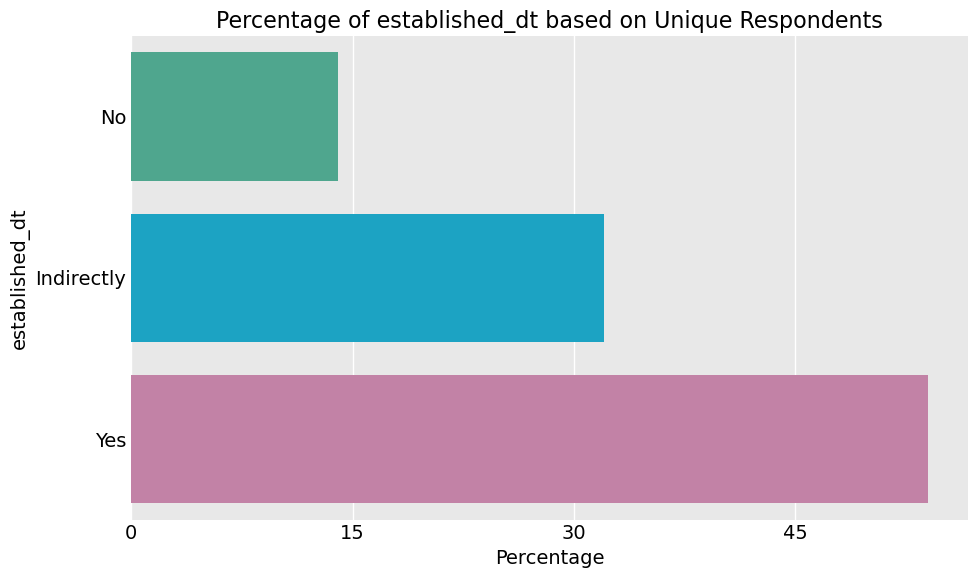

In [835]:
barplot(df, 'established_dt',palette=['#40B595','#00B4DF','#CC78A7'],outfile='report_plots/established.svg')

In [836]:
df.groupby('established_dt')['_id'].count()/50*100


established_dt
Indirectly    32.0
No            14.0
Yes           54.0
Name: _id, dtype: float64

**2. In-House Assurance Practices Prevail**  
The majority of respondents (68%) conduct assurance internally, with most relying on non-specialized teams for this process. Only 6% of respondents use external services, such as third-party assurance providers, while 18% of respondents themselves provide third-party assurance services. This suggests a strong preference for in-house assurance, though often with limited specialization.

/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_27901/2203052376.py:124: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




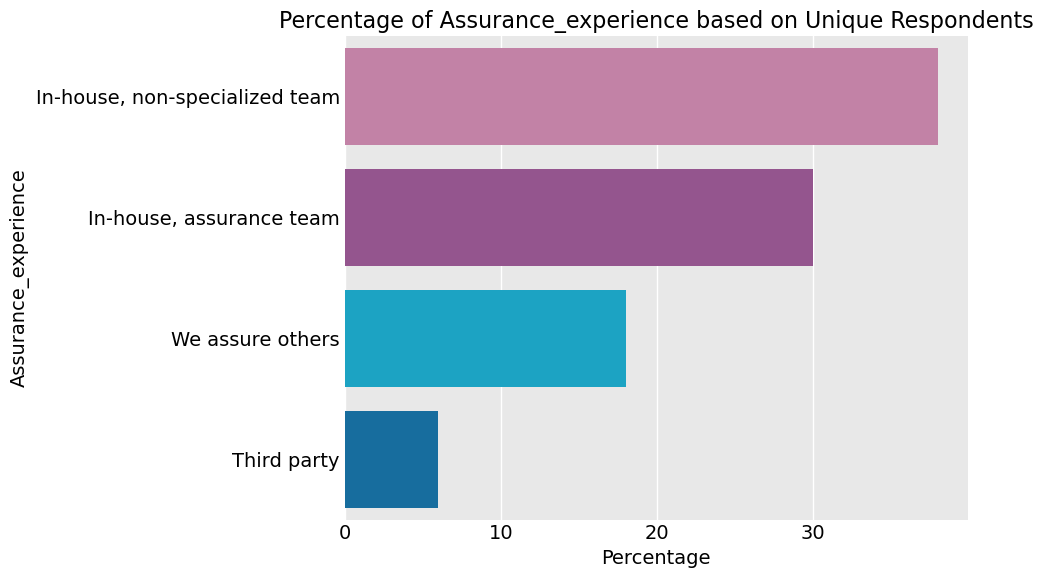

In [837]:
replacement_dict={
    'In-house assurance team':'In-house, assurance team',
    'In-house, non-specialized team':'In-house, non-specialized team',
    'External third-party':'Third party',
    'We provide assurance services for clients': 'We assure others'
    }
primary_colors = ['#CC78A7','#9F4A96','#00B4DF','#0073B4']

df['Assurance_experience'] = df['Assurance_experience'].replace(replacement_dict)
barplot(df, 'Assurance_experience',palette=primary_colors,category_order=['In-house, non-specialized team','In-house, assurance team','We assure others','Third party'],outfile='report_plots/experience.svg')

In [838]:
df.groupby('Assurance_experience')['_id'].count() / df['_id'].count() * 100

Assurance_experience
In-house, assurance team          30.0
In-house, non-specialized team    38.0
Third party                        6.0
We assure others                  18.0
Name: _id, dtype: float64

**3. Varied Understanding of Assurance in Digital Twins**
The understanding of assurance varied widely among respondents. Some focused on specific properties of digital twins, while others emphasized the broader goal of increasing trust. Key themes included validation, verification, and testing, with many responses mentioning trust and confidence as the primary outcomes. Specific goals such as accuracy, utility, privacy, and reliability were commonly mentioned, but safety and compliance were less prominent. For example:

- "We ensure a digital twin is having the impact anticipated and operating effectively."
- "DT has been designed in accordance with requirements and is fulfilling them."
- "Continuous validation and verification against real-world conditions."
- "Verification and validation that the data is as intended."
- "Independent validation of transparency, security, and trustworthiness in the data, processes, and purpose of the digital twin."

The diversity in responses indicates that assurance is not yet a mature or consistently shared concept across the digital twin community.

In [839]:
# Display a subset of columns
display(df[['assurance_meaning']].head(5))

# count number of words in df
cells = df['assurance_meaning'].values.flatten()
word_counts = [len(str(cell).split()) for cell in cells]
print(f"Minimum number of words: {min(word_counts)}")
print(f"Maximum number of words: {max(word_counts)}")
print(f"Average number of words: {sum(word_counts) / len(word_counts):.2f}")

,assurance_meaning
0,Assurance means digital twins are trustworthy
1,Reproducibility and accuracy of the DT
2,It means the digital twins should be explainab...
3,Assurance is the process and mechanisms by whi...
4,To provide security about a certain topic like...


Minimum number of words: 1
Maximum number of words: 95
Average number of words: 22.18


In [840]:
# ADD word cloud here

**RQ: What practices are being used, including methods and properties assured?**  

In [841]:
df['mechanism_count'] = df['assurance_mechanism_combined'].apply(lambda x: len(x) if isinstance(x, list) else 0)
hist_values, bin_edges = np.histogram(df['mechanism_count'], bins=range(1, df['mechanism_count'].max() + 2))
cumulative_counts = np.cumsum(hist_values)

# Find the value where the cumulative count reaches 50% or more
majority_value = bin_edges[np.argmax(cumulative_counts >= cumulative_counts[-1] / 2)]

# Print the insight
print(f"The majority of people choose {majority_value} assurance mechanisms or less to be currently applied by them.")

The majority of people choose 4 assurance mechanisms or less to be currently applied by them.


/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_27901/2203052376.py:124: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




The most frequently applied assurance mechanisms were ['Data Quality Checks' 'Risk Assessment' 'Stakeholder Feedback Systems']
The least selected assurance mechanisms were ['Service Continuity Management' 'Bias Reviews' 'Governance' 'Oversight'
 'Claims-based assurance' 'Maturity assessment']


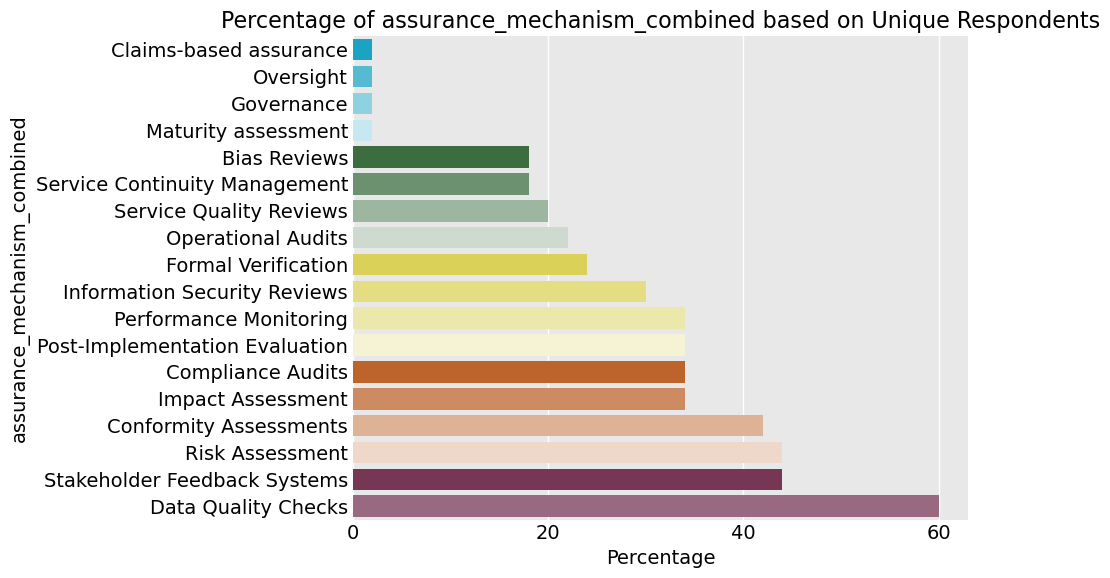

In [842]:
df_exploded = df.explode('assurance_mechanism_combined').reset_index(drop=True)
df_exploded['assurance_mechanism_combined'].value_counts()[:3]

top_3_mechanisms = df_exploded['assurance_mechanism_combined'].value_counts()[:3]
print(f'The most frequently applied assurance mechanisms were {top_3_mechanisms.index.values}')
top_3_mechanisms = df_exploded['assurance_mechanism_combined'].value_counts()[-6:]
print(f'The least selected assurance mechanisms were {top_3_mechanisms.index.values}')

mycolor = select_colors(18, ["Cyan", "Green", "Lemon", "Red", "Purple"])
barplot(df_exploded, 'assurance_mechanism_combined',palette=mycolor)

**3. Assurance Focuses on Technical and Economic Performance**  
Most respondents assure approximately seven or fewer properties of digital twins, focusing primarily on technical and economic performance. Societal properties, such as safety and trustworthiness, are assured to a lesser extent, with ethical, legal, and regulatory aspects being even less frequently addressed. Ecosystem integration properties, except for interoperability, were the least selected, highlighting gaps in broader assurance considerations.

In [843]:
df_exploded = df.explode('assured_properties_combined').reset_index(drop=True)
group_properties = {
    'Technical Performance': [
        'Data Quality', 'Reliability/Robustness', 'Security', 
        'Resilience/ Fault tolerance', 'Data Stewardship', 'Accuracy'
    ],
    'Ecosystem Integration': [
        'Interoperability', 'Evolution', 'Federation'
    ],
    'Ethical': [
        'Explainability', 'Ethical Integrity', 'Sustainability', 
        'Fairness', 'Social Justice'
    ],
    'Societal': [
        'Openness', 'Safety', 'Public Good', 'Trustworthiness'
    ],
    'Economic': [
        'Fit-for-purpose', 'Financial Performance', 'Value Creation', 'Sustainability'
    ],
    'Legal & Regulatory': [
        'Governance', 'Contestability', 'Transparency', 'Accountability'
    ]
}

# Define the primary colors to be used for each group
primary_colors = [
    ["#5DA899", "#85BEB2", "#AED3CC", "#D6E9E5"],  # Teal
    ["#337538", "#66976A", "#99BA9B", "#CCDCCD"],  # Greens
    ["#D9CC70", "#F4EB71", "#F7F1A0", "#FBF8D0"],  # Yellow
    [ "#E69F03", "#ECB742", "#F2CF81", "#F9E7C0"],# Oranges
    ["#812C55",'#B777B0','#CFA4CA','#E7D2E5'], #Purples
    ["#4096C7", "#40C7E7", "#80D9EF","#BFECF7","BFDCEC"]  #Blues
]

stacked_barplot(df_exploded, 'assured_properties_combined', group_properties, 
                category_order=['Ecosystem Integration','Legal & Regulatory','Ethical','Societal','Economic','Technical Performance'], 
                palette=primary_colors,
                outfile="report_plots/properties_currently_assured.svg")


/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_27901/2203052376.py:173: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



In [844]:
df['properties_count'] = df['assured_properties_combined'].apply(lambda x: len(x) if isinstance(x, list) else 0)
# Create a histogram and calculate the cumulative distribution
hist_values, bin_edges = np.histogram(df['properties_count'], bins=range(1, df['properties_count'].max() + 2))
cumulative_counts = np.cumsum(hist_values)

# Find the value where the cumulative count reaches 50% or more
majority_value = bin_edges[np.argmax(cumulative_counts >= cumulative_counts[-1] / 2)]

# Print the insight
print(f"The majority of people choose {majority_value} properties or less currently assured for by them.")

The majority of people choose 7 properties or less currently assured for by them.


In [845]:
top_3_properties = df_exploded['assured_properties_combined'].value_counts()[:3]
print(f'The most frequently considered properties were {top_3_properties.index.values}')

The most frequently considered properties were ['Data Quality' 'Fit-for-purpose' 'Interoperability']


In [846]:
top_3_properties = df_exploded['assured_properties_combined'].value_counts()[-4:]
print(f'The properties least considered during assurance were {top_3_properties.index.values}')

The properties least considered during assurance were ['Evolution' 'Contestability' 'Accuracy' 'Social Justice']


**5. Mixed Satisfaction with Assurance Practices and Communication**  
To understand satisfaction with current assurance practices, respondents were asked how satisfied they were with how their team identifies and documents requirements, actions, and decisions in their assurance process. We also provided three statements related to assurance integration, communication, and alignment with higher-level principles, and asked respondents to rate their level of agreement on a Likert scale from 1 (strongly disagree) to 5 (strongly agree).

Overall, respondents reported a high level of satisfaction with their assurance activities, particularly in the effectiveness of communicating assurance to build stakeholder trust. The majority agreed that assurance activities are substantively integrated into operational practices and that these activities can be clearly linked to higher-level trustworthiness and ethical principles. However, there was also a notable minority who disagreed with these statements, indicating variability in how assurance practices are perceived and implemented. This divergence may partly explain why 16% of respondents reported being unsatisfied with their overall assurance process.

In [847]:
def centered_likert_plot(df_opinion, palette_left=None, palette_right=None, left_columns=None, right_columns=None, xaxis_range=[-20, 80], output_file="output.svg"):
    fig = go.Figure()

    # Plot left columns (negative values) if they are provided
    if left_columns and palette_left:
        for i, col in enumerate(left_columns):
            fig.add_trace(go.Bar(
                x=-df_opinion[col].values,  # Plot negative values
                y=df_opinion.index,
                orientation='h',
                name=col,
                customdata=df_opinion[col],
                hovertemplate="%{y}: %{customdata}",
                marker_color=color_hex_codes.get(palette_left[i]),
                marker_line_color='white',
                marker_line_width=3
            ))

    # Plot right columns (positive values) if they are provided
    if right_columns and palette_right:
        for i, col in enumerate(right_columns):
            fig.add_trace(go.Bar(
                x=df_opinion[col].values,  # Plot positive values
                y=df_opinion.index,
                orientation='h',
                name=col,
                hovertemplate="%{y}: %{x}",
                marker_color=color_hex_codes.get(palette_right[i]),
                marker_line_color='white',
                marker_line_width=3
            ))

    # Update layout
    fig.update_layout(
        barmode='relative',
        height=400,
        width=1000,
        yaxis_autorange='reversed',
        legend_orientation='h',
        legend_x=-0.05, legend_y=1.1,
        bargap=0.2,  # Space between bars
        bargroupgap=0.1,  # Space between groups
        xaxis_range=xaxis_range,
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=False),
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(size=12)  # Font size 12px
    )

    # Save the plot as an SVG
    fig.write_image(output_file, format="svg")

    # Show the plot
    fig.show()

sel_df = df[['integrate_assurance','communication_impact','link_assurance_activities']]
df_melted = sel_df.melt(var_name='Category', value_name='Response')

# Using pd.crosstab to create the pivot-style table
df_opinion = pd.crosstab(df_melted['Category'], df_melted['Response'])

# Define the custom order
custom_order = ['communication_impact', 'link_assurance_activities', 'integrate_assurance']

# Convert the index to a categorical type with the custom order
df_opinion.index = pd.Categorical(df_opinion.index, categories=custom_order, ordered=True)

# Sort by the custom index order
df_opinion = df_opinion.sort_index()
df_opinion = df_opinion/50*100
df_opinion

Response,Agree,Disagree,Neutral,Strongly agree,Strongly disagree
communication_impact,54.0,2.0,12.0,26.0,6.0
link_assurance_activities,34.0,10.0,28.0,24.0,4.0
integrate_assurance,42.0,8.0,26.0,16.0,8.0


In [848]:
centered_likert_plot(df_opinion, palette_left=['Red_50','Red'], palette_right=['Teal_50','Teal'], left_columns=['Disagree','Strongly disagree'], right_columns=['Agree','Strongly agree'], xaxis_range=[-30, 80], output_file="report_plots/perception_assurance.svg")


In [849]:
centered_likert_plot(df_opinion, palette_right=['Gray'], right_columns=['Neutral'], xaxis_range=[-30, 80], output_file="report_plots/perception_neutral_assurance.svg")

In [850]:
sel_df = df[['satisfaction_justification']]
df_melted = sel_df.melt(var_name='Category', value_name='Response')
# Using pd.crosstab to create the pivot-style table
df_opinion = pd.crosstab(df_melted['Category'], df_melted['Response'])
df_opinion = df_opinion/50*100
df_opinion


Response,Neutral,Somewhat satisfied,Somewhat unsatisfied,Very satisfied,Very unsatisfied
Category,,,,,
satisfaction_justification,24.0,34.0,18.0,18.0,6.0


In [851]:
centered_likert_plot(df_opinion, palette_left=['Magenta_50','Magenta'], palette_right=['Blue_50','Blue'], left_columns=['Somewhat unsatisfied','Very unsatisfied'], right_columns=['Somewhat satisfied','Very satisfied'], xaxis_range=[-30, 80], output_file="report_plots/satisfaction_assurance.svg")

In [852]:
centered_likert_plot(df_opinion, palette_right=['Gray'], right_columns=['Neutral'], xaxis_range=[-30, 80], output_file="report_plots/satisfaction_neutral_assurance.svg")

## Gemini Principles

**6. High Relevance but Limited Practical Value of Guiding Principles**  
To understand perceptions of guiding principles like the Gemini Principles, respondents were asked about their familiarity, use, and the relevance of these principles. Over 60% of respondents reported being somewhat familiar, with 30% actively using them as guidelines. The remaining respondents either had limited knowledge or were introduced to the principles for the first time through the survey.

/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_27901/2203052376.py:124: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




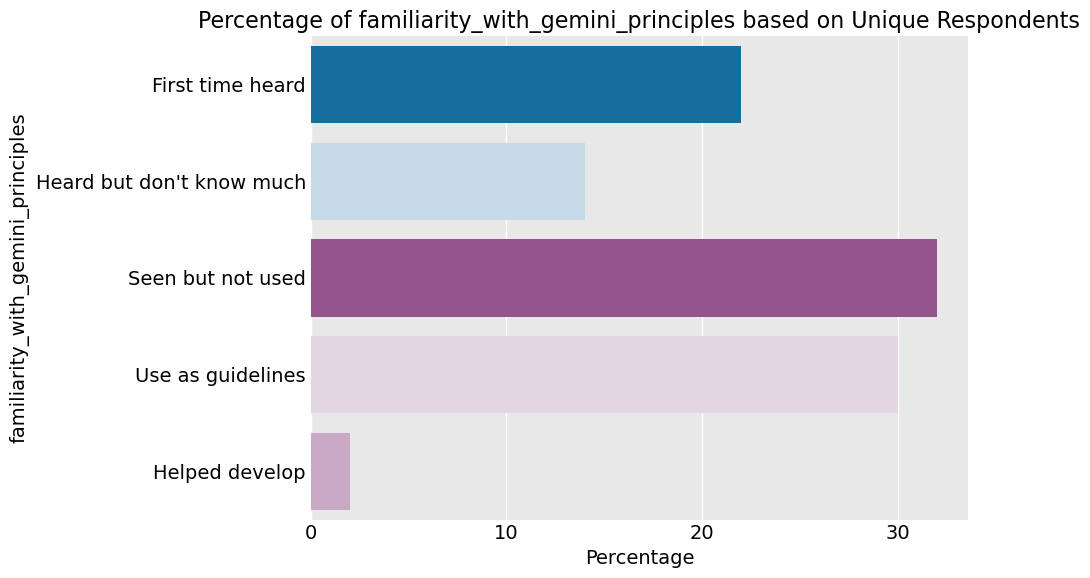

In [853]:
# Mapping dictionary for shortening the responses
shorten_mapping = {
    "I've seen them but don't use them in my work.": "Seen but not used",
    "This is the first time I've heard of them.": "First time heard",
    "I've heard of them but don't know much.": "Heard but don't know much",
    "I incorporate them in my work as guidelines.": "Use as guidelines",
    "I have helped develop them.": "Helped develop"
}

# Replace the long responses with the shortened versions
df['familiarity_with_gemini_principles'] = df['familiarity_with_gemini_principles'].replace(shorten_mapping)

# Step 2: Categorize the responses into 'familiar' and 'unfamiliar' using a lambda function
df['familiarity_binary'] = df['familiarity_with_gemini_principles'].apply(
    lambda x: 'familiar' if x in ["Use as guidelines", "Seen but not used", "Helped develop"] else 'unfamiliar'
)
plot_pie_chart(df, 'familiarity_with_gemini_principles', title="Overall freq per mechanims",dpull=0)


mycolor = select_colors(5, ["Blue", "Blue_75", "Magenta", "Magenta_75","Magenta_50"])
barplot(df, 'familiarity_with_gemini_principles',
        category_order=["First time heard","Heard but don't know much","Seen but not used", "Use as guidelines", "Helped develop"], 
        palette=mycolor,
        outfile='report_plots/gemini_familiarity.svg')


When asked to rate the relevance of each principle, most respondents indicated that they found them "very" or "extremely relevant," showing strong overall agreement on their importance. However, when assessing their practical value, responses were more mixed, with many considering the principles only "moderately valuable." This paradox suggests that while the principles are recognized as the right set of guidelines, they are not perceived as valuable in practice—likely because they are challenging to effectively implement.

[ 2.  0.  2.  8. 10. 10. 10. 12. 18. 28.]


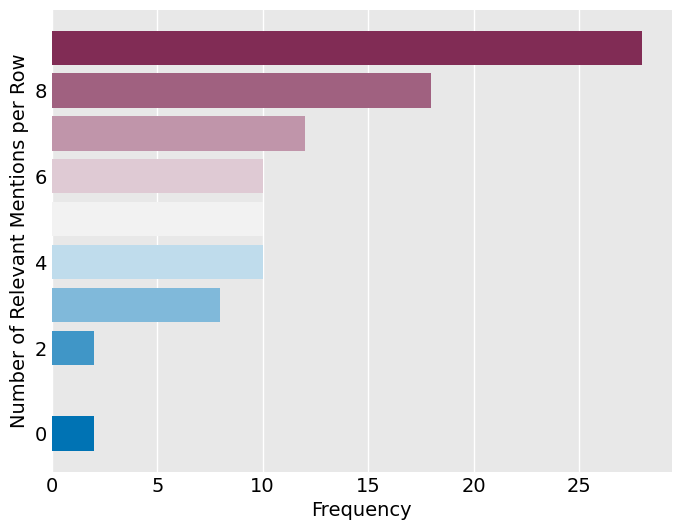

In [854]:
relevance_columns = [col for col in df.columns if col.startswith('relevance_')]
relevance_columns.append('_id')
df_gemini = df[relevance_columns].copy()

def count_relevance(row):
    return row.apply(lambda x: x in ['Very', 'Extremely Relevant']).sum()

# Apply the function to each row
df_gemini['Relevance_Count'] = df_gemini.apply(count_relevance, axis=1)

# Generate a custom color palette (9 shades of blue mixed with white)
colors = ['#0073B4', '#E8E8E8', '#4096C7', '#80B9DA', '#BFDCEC', '#F2F2F2','#DFCAD4', '#C095AA', '#A06180','#812C55']
# Plot horizontal bar chart
plt.figure(figsize=(8, 6))

# Create the horizontal histogram
counts, bins = np.histogram(df_gemini['Relevance_Count'], bins=range(df_gemini['Relevance_Count'].min(), df_gemini['Relevance_Count'].max() + 2))

# percentages
total_counts = np.sum(counts)
percentages = (counts / total_counts) * 100
print(percentages)
plt.barh(bins[:-1], percentages, color=colors[:len(counts)])

# Customize the grid and background
ax = plt.gca()  # Get current axes
ax.set_facecolor('#E8E8E8')  # Set grey background
ax.grid(axis='x', color='white', linestyle='-', linewidth=1)  # White vertical lines
ax.grid(axis='y', linestyle='')  # Remove horizontal lines
ax.tick_params(length=0)  # Remove tick marks

# Ensure the bars are in front of the grid lines
for bar in ax.patches:
    bar.set_zorder(3)

# Remove the black frame (spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add titles and labels
plt.xlabel('Frequency')
plt.ylabel('Number of Relevant Mentions per Row')

# Show the plot
plt.savefig("report_plots/gemini_high_relevance.svg", format="svg")
plt.show()

/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_27901/2203052376.py:124: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




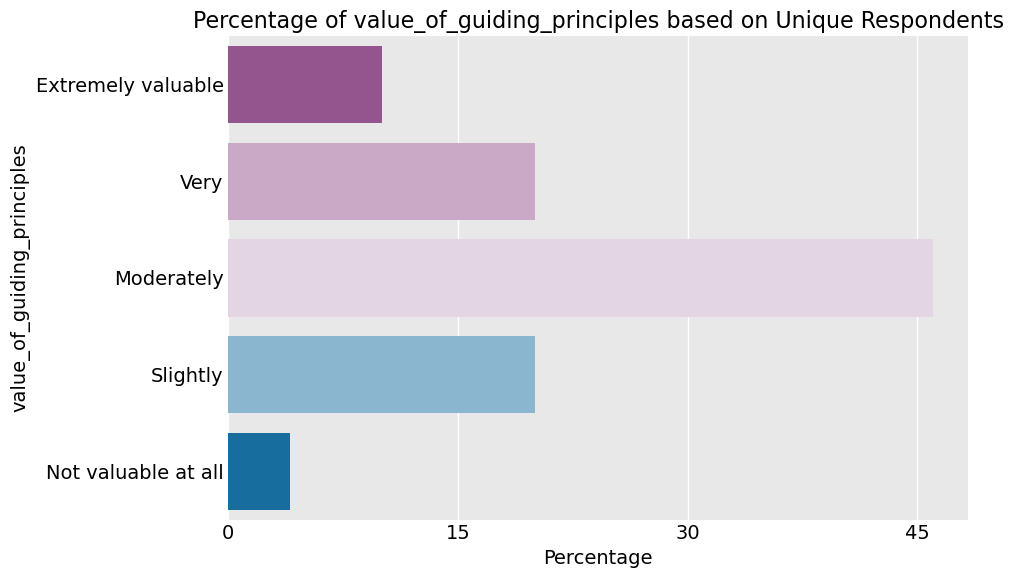

In [855]:
mycolor = select_colors(5, ["Magenta", "Magenta_50", "Magenta_75", "Blue_50", "Blue"])
barplot(df, 'value_of_guiding_principles', 
        palette=mycolor,
        category_order=['Extremely valuable','Very','Moderately','Slightly','Not valuable at all'],
        outfile='report_plots/gemini_value.svg')


**7. High Relevance Ratings Across All Principles**  
All guiding principles were rated as either "Very" or "Extremely Relevant" by the majority of respondents, indicating a broad consensus on their overall importance. Among these, "Insight," "Value," and "Quality" were rated most highly, reflecting their particular significance within the community.

In [856]:
df_relevance = long_df.groupby(['term', 'relevance']).size().unstack(fill_value=0)
inverse_map = {v: k for k,v in relevance_map.items()}
df_relevance.rename(columns=inverse_map,inplace=True)
df_relevance['sum'] = df_relevance['Extremely Relevant'] + df_relevance['Very']
df_relevance = df_relevance.sort_values(by=['sum'],ascending=False)

fig = go.Figure()
palette_left = ['Teal_50','Teal']
palette_right = ['Orange_75','Orange_50','Orange']

for i,col in enumerate(df_relevance.columns[[3,4]]):
    fig.add_trace(go.Bar(x=-((df_relevance[col].values/50) *100),
                         y=df_relevance.index,
                         orientation='h',
                         name=col,
                         customdata=df_relevance[col],
                         hovertemplate = "%{y}: %{customdata}",
                         marker_color=color_hex_codes.get(palette_left[i]),
                         marker_line_color='white',  
                         marker_line_width=3  ))
for i,col in enumerate(df_relevance.columns[[2,1,0]]):
    fig.add_trace(go.Bar(x= ((df_relevance[col].values/50) *100),
                         y =df_relevance.index,
                         orientation='h',
                         name= col,
                         hovertemplate="%{y}: %{x}",
                         marker_color=color_hex_codes.get(palette_right[i]),
                         marker_line_color='white',  
                         marker_line_width=3  ))  
    


fig.update_layout(barmode='relative', 
                  height=400, 
                  width=700, 
                  yaxis_autorange='reversed',
                  legend_orientation ='h',
                  legend_x=-0.05, legend_y=1.1,
                  bargap=0.2,  # Increased space between the bars
                  bargroupgap=0.1,
                  plot_bgcolor='white',  
                  paper_bgcolor='white' 
                 )
fig.write_image("report_plots/relevance_stacked.svg", format="svg")
fig.show()


**8. Mixed perceived Challenges across Principles**
For all principles (except those rated as irrelevant), respondents were asked to rate how challenging each principle was to implement. While "Moderately Challenging" was the most common response across all principles, notable differences emerged in the more extreme ratings. "Federation" received the most "Extremely Challenging" ratings, followed by "Evolution" and "Security." In contrast, "Insight" was the only principle never rated as extremely challenging and was generally seen as less challenging. Interestingly, the principles of "Curation" and "Openness" had symmetric extreme responses, with equal numbers finding them either not at all challenging or extremely challenging, possibly reflecting differences in sector or stages of digital twin adoption.

In [857]:
df_challenge = long_df.groupby(['term', 'challenge']).size().unstack(fill_value=0)
inv_challenge_map = {v:k for k,v in challenge_map.items()}
df_challenge.rename(columns=inv_challenge_map,inplace=True)
#df_challenge['sum'] = df_challenge['Extremely challenging'] + df_challenge['Very']
#df_challenge = df_challenge.sort_values(by=['sum'],ascending=False)
df_challenge = df_challenge.reindex(df_relevance.index)
df_challenge['sum'] = df_challenge['Extremely challenging'] + df_challenge['Very']
df_challenge = df_challenge.sort_values(by=['sum'],ascending=False)
fig = go.Figure()
palette_left = ['Blue_50','Blue_25']
palette_right = ['Purple_75','Purple_50','Purple']

for i,col in enumerate(df_challenge.columns[[3,4]]):
    fig.add_trace(go.Bar(x=-((df_challenge[col].values/50) *100),
                         y=df_challenge.index,
                         orientation='h',
                         name=col,
                         customdata=df_challenge[col],
                         hovertemplate = "%{y}: %{customdata}",
                         marker_color=color_hex_codes.get(palette_left[i]),
                         marker_line_color='white',  
                         marker_line_width=3 ))
for i,col in enumerate(df_challenge.columns[[1,0]]):
    fig.add_trace(go.Bar(x= ((df_challenge[col].values/50) *100),
                         y =df_challenge.index,
                         orientation='h',
                         name= col,
                         hovertemplate="%{y}: %{x}",
                         marker_color=color_hex_codes.get(palette_right[i]),
                         marker_line_color='white',  
                         marker_line_width=3  ))    

fig.update_layout(barmode='relative', 
                  height=400, 
                  width=700, 
                  yaxis_autorange='reversed',
                  legend_orientation ='h',
                  legend_x=-0.05, legend_y=1.1,
                  bargap=0.2,  # Increased space between the bars
                  bargroupgap=0.1,
                  xaxis=dict(showgrid=False),  
                  yaxis=dict(showgrid=False),
                  plot_bgcolor='white',  
                  paper_bgcolor='white' 
                 )
fig.write_image("report_plots/challenge_stacked.svg", format="svg")
fig.show()

In [858]:
fig = go.Figure()
palette_right = ['Gray']

for i,col in enumerate(df_challenge.columns[[2]]):
    fig.add_trace(go.Bar(x= ((df_challenge[col].values/50) *100),
                         y =df_challenge.index,
                         orientation='h',
                         name= col,
                         hovertemplate="%{y}: %{x}",
                         marker_color=color_hex_codes.get(palette_right[i]),
                         marker_line_color='white',  
                         marker_line_width=3  ))    

fig.update_layout(barmode='relative', 
                  height=400, 
                  width=700, 
                  yaxis_autorange='reversed',
                  legend_orientation ='h',
                  legend_x=-0.05, legend_y=1.1,
                  bargap=0.2,  # Increased space between the bars
                  bargroupgap=0.1,
                  xaxis=dict(showgrid=False),  
                  yaxis=dict(showgrid=False),
                  plot_bgcolor='white',  
                  paper_bgcolor='white' 
                 )
fig.show()

When comparing principles relative to each other, "Quality" and "Security" emerged in the upper right quadrant, indicating that, relatively speaking, they were the most challenging principles among those rated as most relevant. This variability highlights the complexity of putting these principles into practice and warrants further exploration through in-depth interviews to understand the underlying reasons.

In [859]:
# Mapping strings to numerical values
relevance_map = {
    "Not Relevant": 0,
    "Slightly": 1,
    "Moderately": 2,
    "Very": 3,
    "Extremely Relevant": 4
}

challenge_map = {
    "Not at all challenging": 0,
    "Slightly": 1,
    "Moderately": 2,
    "Very": 3,
    "Extremely challenging": 4
}

# Create a copy of the DataFrame with only the relevance and challenge columns
relevance_challenge_columns = [col for col in df.columns if col.startswith('relevance_') or col.startswith('challenge_')]
df_gemini = df[relevance_challenge_columns].copy()

for col in df.columns:
    if col.startswith('relevance_'):
        df_gemini[col] = df_gemini[col].map(relevance_map)
    elif col.startswith('challenge_'):
        df_gemini[col] = df_gemini[col].map(challenge_map)

In [860]:
def plot_quadrants(df, color_map, add_std=True, filename='newplot', metric='mode', cross_hair=True):    
    fig = px.scatter()
    fig.update_layout(xaxis=dict(range=[1, 3], showgrid=False), yaxis=dict(range=[2, 4], showgrid=False), 
                      plot_bgcolor='rgba(0,0,0,0)',   # Transparent plot background
                      paper_bgcolor='rgba(0,0,0,0)')

    # Add ellipses for each term to represent standard deviation, colored the same as the scatter plot points
    if add_std:
        for i, row in df.iterrows():
            term_color = color_map[row['term']]
            fig.add_shape(type="circle",
                          x0=row[f'challenge_{metric}'] - row['challenge_std'], y0=row[f'relevance_{metric}'] - row['relevance_std'],
                          x1=row[f'challenge_{metric}'] + row['challenge_std'], y1=row[f'relevance_{metric}'] + row['relevance_std'],
                          line_color='rgba(0, 0, 0, 0)',
                          fillcolor=term_color,
                          line=dict(width=0),
                          opacity=0.15)

    # Now add the scatter plot of jittered mean values on top of the shapes
    mean_scatter = px.scatter(df, x=f'challenge_{metric}', y=f'relevance_{metric}', color='term',
                              labels={f'challenge_{metric}': 'Average Challenge', 'relevance_{metric}': 'Average Relevance'},
                              color_discrete_map=color_map)
    for trace in mean_scatter.data:
        fig.add_trace(trace)
    fig.update_traces(marker=dict(size=15))

    # Add fixed quadrant lines at absolute means
    if cross_hair:
        mean_challenge = df[f'challenge_{metric}'].mean()
        mean_relevance = df[f'relevance_{metric}'].mean()
        fig.add_vline(x=mean_challenge, line=dict(color="black", width=1, dash="dash"), annotation_text=" ", annotation_position="top")
        fig.add_hline(y=mean_relevance, line=dict(color="black", width=1, dash="dash"), annotation_text=" ", annotation_position="right")
            

    fig.update_layout(plot_bgcolor='white', paper_bgcolor='white')
    import plotly.io as pio

    # Set the default renderer to export with a white background
    pio.kaleido.scope.default_format = "svg"  # Ensures PNG format
    pio.kaleido.scope.default_width = 800     # Adjust as needed
    pio.kaleido.scope.default_height = 600    # Adjust as needed
    pio.kaleido.scope.default_scale = 1.5     # Adjust as needed
    pio.kaleido.scope.default_background = 'white'  # Set background to white

    # To save the figure directly with a white background
    fig.write_image(f"report_plots/quadrant_gemini.svg")
    fig.show()

In [861]:
terms = [col.split('_')[1] for col in df.columns if col.startswith('relevance_')]
terms = list(set(terms))
long_df = pd.DataFrame()
for term in terms:
    term_df = df_gemini[[f'relevance_{term}', f'challenge_{term}']].copy()
    term_df.columns = ['relevance', 'challenge']
    term_df['term'] = term
    long_df = pd.concat([long_df, term_df], axis=0)
long_df['term'] = long_df['term'].replace('good', 'public good')


In [862]:
# Compute the mean for 'relevance' and 'challenge' for each 'term'
avg_ratings = long_df.groupby('term').agg({
    'relevance': 'mean',
    'challenge': 'mean'
}).reset_index()

# Rename the columns for better readability
avg_ratings.columns = ['term', 'relevance_mean', 'challenge_mean']

In [863]:

# add jitter once
#jitter_strength=0.3
#avg_std_ratings['challenge_mean'] = avg_std_ratings['challenge_mean'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(avg_std_ratings))
#avg_std_ratings['relevance_mean'] = avg_std_ratings['relevance_mean'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(avg_std_ratings))


#colors = px.colors.qualitative.Plotly
#color_map = {term: colors[i % len(colors)] for i, term in enumerate(avg_std_ratings['term'].unique())}

color_map = {
    'value': '#FF6347',     # Warm - Red 
    'insight': '#FFA500',   # Warm - Orange 
    'quality': '#FFD700',   # Warm - Yellow
    'federation': '#1E90FF',# Cool - DodgerBlue
    'security': '#4169E1',  # Cool - RoyalBlue
    'evolution': '#9370DB', # Cool - MediumPurple
    'openness': '#32CD32',  # Other - LimeGreen
    'public good': '#8B4513',      # Other - SaddleBrown
    'curation': '#FFDAB9'   # Other - PeachPuff
}

plot_quadrants(avg_std_ratings, color_map, add_std=False, filename='2D_all_principles_mean.svg', metric='mean')

**9. Mixed Interest in Connected Digital Twins and Challenges in Establishing Trust**  
Only 55% of respondents reported considering sharing data or models with other organizations to build connected digital twins, which may explain why the "Federation" principle received relatively low relevance ratings. This suggests that not all digital twin practitioners are focused on creating connected digital twins. Among those who did pursue connected twins, 67% found it difficult to establish trust in the resulting shared digital twin. The challenges reported included a broad range of issues, with the most common being intellectual property rights, data confidentiality, interoperability, and insufficient digital awareness. This indicates that for those who find "Federation" relevant, it is often perceived as highly challenging to implement.


In [864]:
print('Question: Have you considered sharing data or models with other organisations (or across partners within an organisation) to form **connected digital twins**?')
print('If yes, how difficult is it to establish trust in the competence, goodwill and value of the resulting shared digital twin?')
# Create sunburst plot
# Set 'partner_trust_difficulty' to None where 'asset_data_sharing' is 'No'
df.loc[df['asset_data_sharing'] == 'No', 'partner_trust_difficulty'] = ''

df['partner_difficulty'] = df['partner_trust_difficulty'].replace({
    'Very Difficult': 'Difficult',
    'Somewhat Difficult': 'Difficult',
    'Neutral': 'Neutral/NA',
    'Not Applicable': 'Neutral/NA',
    'Somewhat Easy': 'Easy'
})

# Group by the relevant columns and count occurrences
grouped_df = df.groupby(['asset_data_sharing', 'partner_difficulty']).size().reset_index(name='count')
fig = px.sunburst(grouped_df, path=['asset_data_sharing', 'partner_difficulty'], values='count', branchvalues='total')
# Add custom labels for inner and outer circles
fig.update_traces(textinfo='label+percent parent')
fig.show()

Question: Have you considered sharing data or models with other organisations (or across partners within an organisation) to form **connected digital twins**?
If yes, how difficult is it to establish trust in the competence, goodwill and value of the resulting shared digital twin?


In [865]:
df.groupby(['asset_data_sharing','reliance_on_evidence'])['reliance_on_evidence'].count()

asset_data_sharing  reliance_on_evidence
Yes                 Completely              1
                    Moderately              8
                    Not at all              3
                    Slightly                8
                    Very much               7
Name: reliance_on_evidence, dtype: int64

In [866]:
# Melt columns
trust_challenge_columns = [col for col in df.columns if col.startswith('partner_trust_challenges[')]
trust_challenge_melted = melt_multiple_select(df, trust_challenge_columns, 'trust challenges',)

top_3_trust_challenges = trust_challenge_melted['trust challenges'].value_counts()[:3]
print(f'The most frequently reported challenges for partnering around connected digital twins were {top_3_trust_challenges.index.values}')

The most frequently reported challenges for partnering around connected digital twins were ['Intellectual Property Rights' 'Concerns re confidentiality of data'
 'Interoperability']


In [867]:
df['properties_count'] = df['partner_trust_challenges_combined'].apply(lambda x: len(x) if isinstance(x, list) else 0)
# Create a histogram and calculate the cumulative distribution
hist_values, bin_edges = np.histogram(df['properties_count'], bins=range(1, df['properties_count'].max() + 2))
cumulative_counts = np.cumsum(hist_values)

# Find the value where the cumulative count reaches 50% or more
majority_value = bin_edges[np.argmax(cumulative_counts >= cumulative_counts[-1] / 2)]

# Print the insight
print(f"The majority of people report {majority_value} challenges or less when building trust with sharing partners.")

The majority of people report 5 challenges or less when building trust with sharing partners.


**10. Key Challenges in Implementing the Gemini Principles: Uncertainty, Lack of Standards, and Communication Barriers**  
The main challenges reported when putting the Gemini Principles into practice were categorized into four key themes: "Not knowing how," "Communicating value," "Data Concerns," and "Lack of consistency."

The theme "Not knowing how" best encapsulates a sense of uncertainty among respondents, often reflecting an inability to determine where to begin or a lack of the necessary knowledge, including the absence of appropriate metrics or KPIs. This theme was especially prominent for principles like "Public good," "Evolution," and "Value," highlighting that the digital twin space is still developing and that some sectors exhibit lower maturity when addressing these foundational concepts. For instance:
- “It is not clear what public good in perpetuity would look like.”
- “It is hard to objectively measure public good.”
- “Terms are not well enough defined in our context.”

"Data Concerns" and "Lack of consistency" often co-occurred, encompassing issues ranging from specific data quality problems to broader challenges like the absence of consistent standards across the community. Examples include:  
- “The acquisition of data on which digital twins are typically built is generally not standard in medical practice.”  
- “Lack of standards and frameworks for data exchange among physical digital twins.”

Finally, the challenge of "Communicating value" was often linked to principles such as "Value," "Openness," and "Federation." Respondents referred to the difficulty of establishing a shared understanding of a digital twin's value among multiple stakeholders. Examples include:  
- “Being able to communicate the value to their end user.”  
- “Interoperability is a challenge (…) including getting partners to understand the opportunity and benefit at a system of systems level.”

These challenges demonstrate that while the Gemini Principles are recognized as important, there are still significant barriers to their implementation, with many sectors struggling to apply these high-level concepts effectively.

In [868]:
## ADD word cloud code

## ABA Readiness


**11. Readiness for Argument-Based Assurance: Interest in Tools but Uncertainty Remains**  
When asked about their readiness for a tool to support argument-based assurance, 48% of respondents indicated that such a tool would enhance trust in their digital twins by helping structure and communicate how assurance measures align with ethical goals. Another 38% expressed interest but required more information to fully understand its utility, while only 14% did not see the value of such a tool. Among those interested, common benefits included the potential for a more standardized approach, improved understanding of both the system and assurance process, and the ability to challenge or revisit assurance arguments. In contrast, those who were not interested in the tool often cited that it was not applicable to their work or did not align with their existing stakeholder communication practices.


In [869]:
plot_pie_chart(df, 'need_for_visual_tool',label_length=10)


**12. Lack of Established Frameworks for Trustworthy and Ethical Digital Twins**  
A significant gap was identified in the foundational understanding of digital twin ethics, with 72% of respondents indicating that their organizations lacked an established definition or framework for trustworthy and ethical digital twins. This highlights a lack of clarity in operationalizing ethical principles, signaling an area for potential development.


In [870]:
#pie_ethics = plot_pie_chart(df, 'ethical_framework_existence')
plot_pie_chart(df, 'ethical_framework_existence',palette=['#40B595','#00B4DF','#80D9EF','#CC78A7','#E5BBD3','#E8E8E8','#F2DDE9'],dpull=0.05,outfile='report_plots/ethics_framework.svg')



**13. Gap in Structuring and Communicating Assurance Cases**  
The majority of respondents (60+%) communicate their assurance work verbally during meetings, with 40% not using any structured approach for this communication. Fewer than 30% use visual aids in their reports, demonstrating a clear gap in effectively structuring and conveying assurance cases across the industry. Although some respondents do follow established standards or use visual aids, further exploration is needed to better understand current practices and identify how TEA could support and integrate with these existing approaches.


/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_27901/2203052376.py:124: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




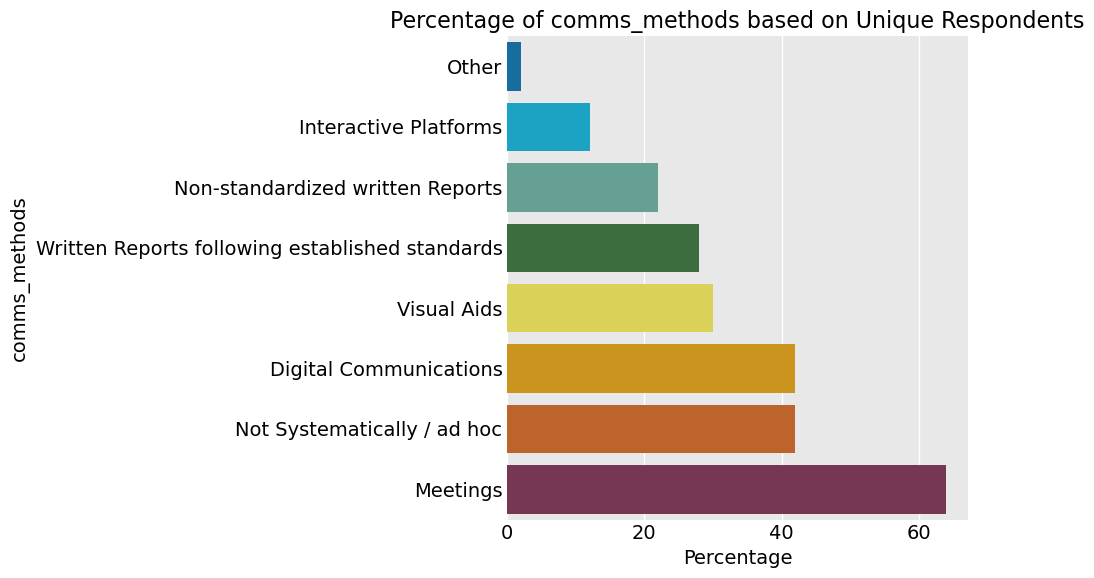

In [871]:
x_columns = [col for col in df.columns if col.startswith('communication_methods')]
x_new = melt_multiple_select(df, x_columns, 'comms_methods')

mycolor = select_colors(8, ["Blue","Cyan", "Teal","Green","Lemon", "Orange","Red", "Purple"])
barplot(x_new, 'comms_methods',palette=mycolor,outfile='report_plots/comms.svg')


**14. Value Demonstration and Skills Training Identified as Key Needs for Tool Adoption**  
When asked about the support needed to adopt the TEA tool and create assurance cases around ethical principles, the majority of respondents indicated that they would require a value demonstration to justify building an assurance case, emphasizing the need for a clear business justification. Additionally, a significant number of respondents highlighted their lack of expertise in implementing assurance tools as a major challenge, making skills training the second most requested form of support. A substantial number of respondents selected costs and lack of time as potentail challenges, although those were chosen to a lesser degree. The least frequently selected challenges were around internal resistance and integration with governance process or tech stack. Interestingly, community forums were the least selected support option, chosen by only 24% of respondents, suggesting a preference for more direct or formal methods of learning and engagement.

In [873]:
challenges_columns = [col for col in df.columns if col.startswith('challenges_adoption')]
challenges_melted = melt_multiple_select(df, challenges_columns, 'challenges_adoption',)
plot_pie_chart(challenges_melted, 'challenges_adoption')

/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_27901/2203052376.py:124: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_27901/2203052376.py:152: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



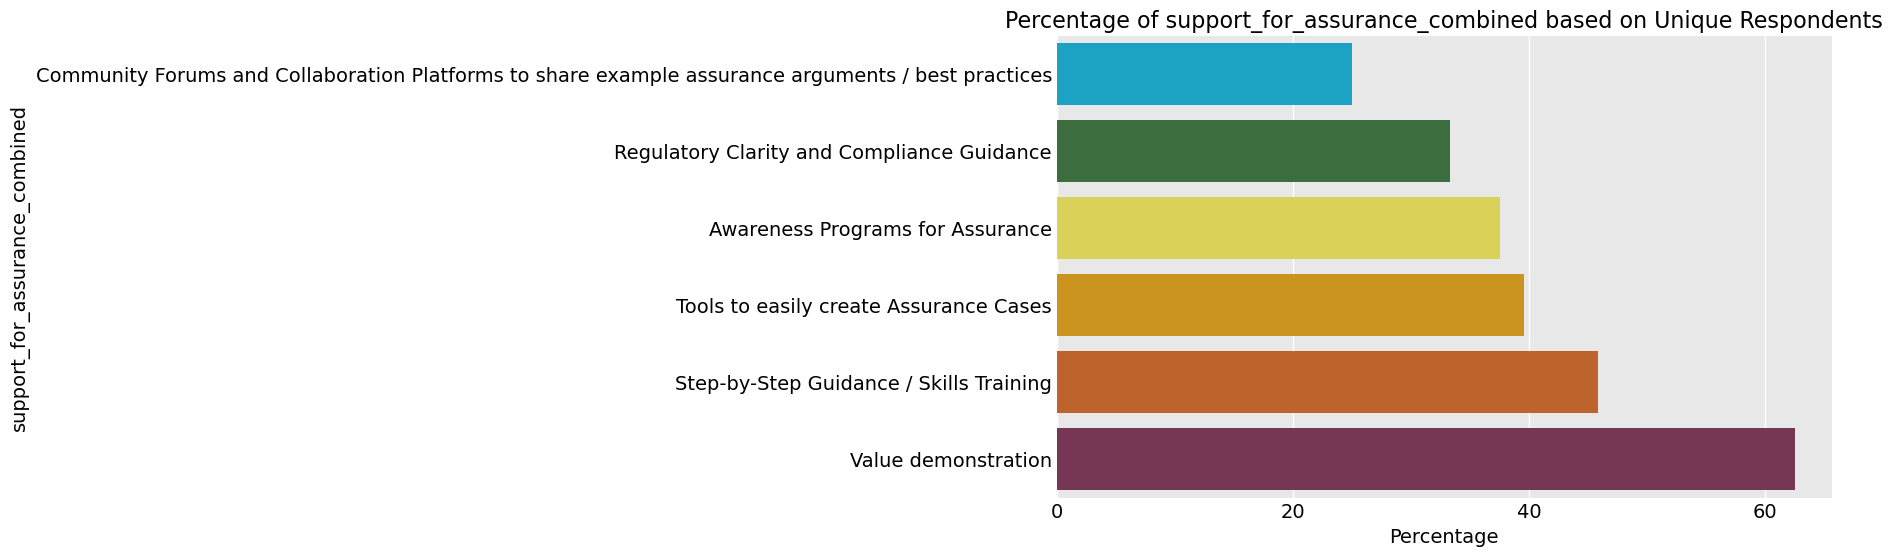

In [875]:
mycolor = select_colors(6, ["Cyan", "Green", "Lemon", "Orange","Red", "Purple"])
support_exploded = support_exploded[support_exploded['support_for_assurance_combined']!='nan']

barplot(support_exploded, 'support_for_assurance_combined',palette=mycolor,outfile='report_plots/support_tool.svg')
